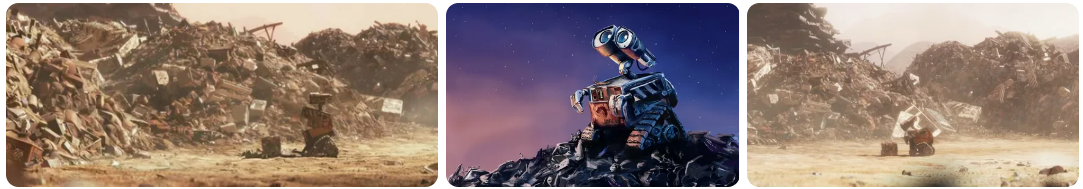

# Отслеживание объектов на ленте конвейера
**Хакатон компании Ренью**

**Задача**:  Создать трекер для отслеживания движущихся объектов на ленте конвейера мусороперерабатывающего завода (пластиковые бутылки разных типов)
  
**Заказчик**: Renue, IT-компания г. Екатеринбург

**Сроки проекта**: 19/08/24 - 09/09/24.

**Стек технологий**: cv2, ultralytics, YOLO8, BoT-SORT, ByteTrack, SORT, DeepSORT.

**Описание**

На мусороперерабатывающем заводе над конвейерной лентой установлена камера, которая фиксирует движение пластикового мусора. Данные в потоке передаются детектору и трекеру, которые определяют тип мусора и координаты bounding box.
  
Необходимо улучшить работу трекера:
  - получение более точных координат bounding box
  - обеспечить устойчивость прослеживания объекта без смены ID

**Требования заказчика**
* в течение 2х недель разработать решение для отслеживания объектов на ленте конвейера
* скорость обработки должна быть не более 100мс на кадр
* добиться наилучшего значения метрики MOTA
* подготовить отчет о работе

**Исходные данные**
* Примеры видеозаписей работы конвейера
* Модель детекции и код для ее запуска (пример)
* Датасет в нескольких форматах: MOT, COCO, CVAT
  - изображения
  - разметка

**Состав команды**

- [Альбина](https://github.com/usaeva-a) 👧
- [Татьяна](https://github.com/GilevaTanya) 👩‍🦰
- [Павел](https://github.com/keyboardnorth) 👦

**Консультант, вдохновитель и торопитель**
- [Ирина](https://github.com/falsednk) 👩

## Initial data research

In [1]:
!pip install ultralytics -q
!pip install motmetrics -q
!pip install filterpy -q
!pip install deep-sort-realtime -q
!pip install lapx -q

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import datetime
import sys
import os
from collections import defaultdict
from ultralytics import YOLO
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import motmetrics as mm
from tqdm.notebook import tqdm
from IPython.display import display, clear_output # для отображения в Kaggle
from deep_sort_realtime.deepsort_tracker import DeepSort
import seaborn as sns

In [3]:
# отключение предупреждений; периодически рекомендуется отключать этот блок и смотреть Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# сохранение путей в зависимости выполняется ли код на Kaggle или локально
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    gt_path = '/kaggle/input/tracking-of-bottles/mot_dataset/gt/gt.txt'
    yolo_weights = '/kaggle/input/tracking-of-bottles/Models/Models/ultralytics/yolov10x_v2_4_best.pt'
    video_А24 = '/kaggle/input/tracking-of-bottles/Videos/Videos/31-03-2024-09%3A34%3A24.mp4'
    video_А58 = '/kaggle/input/tracking-of-bottles/Videos/Videos/��������/30-03-2024-09%3A46%3A58.mp4'
    video_А32 = '/kaggle/input/tracking-of-bottles/Videos/Videos/��������/31-03-2024-05%3A56%3A32.mp4'
    
    # файл взят из https://github.com/abewley/sort
    # удалена строка matplotlib.use('TkAgg'), т.к. вызывалась ошибка при визуализации
    sys.path.append(os.path.dirname('/kaggle/input/trackers/sort_without_TkAgg.py'))
    from sort_without_TkAgg import Sort
    
else:
    gt_path = 'initial/Хакатон-Сортировка ТБО/Datasets/mot_dataset/gt/gt.txt'
    yolo_weights = 'initial/Хакатон-Сортировка ТБО/Models/ultralytics/yolov10x_v2_4_best.pt'
    video_А24 = 'initial/Хакатон-Сортировка ТБО/Videos/31-03-2024-09%3A34%3A24.mp4'
    video_А58 = 'initial/Хакатон-Сортировка ТБО/Videos/Смазанные/30-03-2024-09%3A46%3A58.mp4'
    video_А32 = 'initial/Хакатон-Сортировка ТБО/Videos/Смазанные/31-03-2024-05%3A56%3A32.mp4'
    
    from sort_without_TkAgg import Sort 

In [5]:
def create_video_writer(cap, output_filename, frame_width, frame_height):
    '''создание объекта для записи видео'''

    # grab the width, height, and fps of the frames in the video stream.
    #frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    #frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #fps = int(cap.get(cv2.CAP_PROP_FPS)) # скорость, как в исходнике
    fps = 2 # скорость замедлена

    # initialize the FourCC and a video writer object
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    writer = cv2.VideoWriter(output_filename, fourcc, fps,
                             (frame_width, frame_height))

    return writer

In [6]:
def motMetricsEnhancedCalculator(gtSource, tSource, fr_min=1, fr_max=11):
    '''вычисляет MOTA и др. метрики'''
    
    # load ground truth
    gt = np.loadtxt(gtSource, delimiter=',')
    # load tracking output
    try:
        t = np.loadtxt(tSource, delimiter=',')
    except:
        t = tSource
    
    # Create an accumulator that will be updated during each frame
    acc = mm.MOTAccumulator(auto_id=True)
    
    # Max frame number maybe different for gt and t files
    #for frame in range(1, int(gt[:,0].max())+1):      # detection and frame numbers begin at 1
    for frame in range(fr_min, fr_max):    # задаём конкретные фреймы
        
        # select id, x, y, width, height for current frame
        # required format for distance calculation is X, Y, Width, Height \
        # We already have this format
        gt_dets = gt[gt[:,0]==frame,1:6] # select all detections in gt
        t_dets  =  t[t [:,0]==frame,1:6] # select all detections in t
        
        C = mm.distances.iou_matrix(gt_dets[:,1:], t_dets[:,1:], \
                                    max_iou=0.5) # format: gt, t

        # Call update once for per frame.
        # format: gt object ids, t object ids, distance
        acc.update(gt_dets[:,0].astype('int').tolist(), \
                  t_dets[:,0].astype('int').tolist(), C)

    mh = mm.metrics.create()

    return mh.compute(acc, metrics=['num_frames', 'recall', 'precision', 'num_objects',
                                    'num_switches', 'mota', 'motp'], name='acc')

In [7]:
def description(feature):
    '''по списку со значениями времени за фрейм выдаёт распределение и описание'''
    feature = pd.Series(feature, name='ms/fr')
    
    f, ax = plt.subplots(2,2, sharex=True, gridspec_kw={"height_ratios": (.15, .85), 
                                                        "width_ratios": (0.85, 0.15)}, figsize=(9,3.5))
    sns.boxplot(x=feature, ax=ax[0,0])
    sns.histplot(x=feature, bins=100, ax=ax[1,0], element="step",alpha=0.3)
    ax[0,1].remove()
    table(data=feature.describe().astype(int), ax=ax[1,1], loc='right',colWidths=[1.8])
    
    ax[0,0].set(yticks=[], xlabel=None)
    sns.despine(ax=ax[1,0])
    sns.despine(ax=ax[0,0], left=True)
    plt.axis('off')
    f.suptitle('Распределение времени обработки одного фрейма')

### Initial data-tree

```
.
|-- Datasets
|   |-- coco_dataset.zip
|   |-- cvat_for_video.zip
|   |-- images.tar.gz
|   `-- mot_dataset.zip
|-- Models
|   |-- inference.py
|   `-- v2.tar.gz
`-- Videos
    |-- 31-03-2024-09%3A34%3A24.mp4                # от сюда размеченные фреймы (2:30-2:32 - пустая лента)
    |-- 31-03-2024-10%3A13%3A25.mp4
    |-- 31-03-2024-11%3A05%3A35.mp4                # 70% времени пустая двигающаяся лента
    |-- 31-03-2024-11%3A48%3A17.mp4
    |-- 31-03-2024-12%3A32%3A59.mp4                # 15% времени в конце лента стоит
    |-- 31-03-2024-13%3A19%3A13.mp4                # 20% времени в середине лента стоит
    `-- Смазанные
        |-- 30-03-2024-08%3A52%3A47.mp4
        |-- 30-03-2024-08%3A56%3A28.mp4
        |-- 30-03-2024-08%3A59%3A44.mp4
        |-- 30-03-2024-09%3A02%3A53.mp4
        |-- 30-03-2024-09%3A08%3A28.mp4
        |-- 30-03-2024-09%3A12%3A34.mp4            # пустая лента
        |-- 30-03-2024-09%3A29%3A10.mp4            # 20% времени лента стоит пустая
        |-- 30-03-2024-09%3A32%3A39.mp4
        |-- 30-03-2024-09%3A38%3A32.mp4
        |-- 30-03-2024-09%3A41%3A17.mp4            
        |-- 30-03-2024-09%3A46%3A58.mp4
        |-- 30-03-2024-09%3A50%3A01.mp4     # 01(2'30''),34(30'),15(30'),28(10'') идентичны-остановл лента c парой элем
        |-- 30-03-2024-10%3A00%3A34.mp4
        |-- 30-03-2024-11%3A44%3A15.mp4
        |-- 30-03-2024-13%3A40%3A28.mp4
        |-- 31-03-2024-05%3A21%3A32.mp4
        |-- 31-03-2024-05%3A56%3A32.mp4
        |-- 31-03-2024-06%3A35%3A37.mp4
        `-- 31-03-2024-07%3A08%3A04.mp4

4 directories, 31 files
```

### initial markup (gt)

In [8]:
gt_df = pd.read_csv(gt_path, 
                    names = ['fr', 'id', 'x_left', 'y_top', 'w', 'h', '?1', '?2', '?3'],  header = None)
gt_df

,fr,id,x_left,y_top,w,h,?1,?2,?3
0,1,1,840.00,0.0,176.0,124.0,1,2,1.0
1,1,2,612.00,306.0,383.0,397.0,1,2,1.0
2,1,3,990.92,551.0,105.0,186.0,1,2,1.0
3,2,1,838.00,0.0,164.0,184.0,1,2,1.0
4,2,2,605.00,358.0,402.0,409.0,1,2,1.0
...,...,...,...,...,...,...,...,...,...
46526,8999,1683,320.00,572.0,527.0,217.0,1,2,1.0
46527,8999,1684,1220.00,0.0,167.0,236.0,1,2,1.0
46528,9000,1682,583.00,1118.0,281.0,306.0,1,2,1.0
46529,9000,1683,320.00,631.0,527.0,218.0,1,2,1.0


In [9]:
gt_df.isnull().sum() # наличие пропусков

fr        0
id        0
x_left    0
y_top     0
w         0
h         0
?1        0
?2        0
?3        0
dtype: int64

In [10]:
gt_df.describe()

,fr,id,x_left,y_top,w,h,?1,?2,?3
count,46531.000000,46531.000000,46531.000000,46531.000000,46531.000000,46531.000000,46531.000000,46531.000000,46531.0
mean,4863.149212,843.649868,794.298853,618.759398,260.859768,254.691139,0.999914,2.409082,1.0
std,2559.183728,486.661127,351.169090,467.326455,101.153045,115.766574,0.009271,0.854818,0.0
min,1.000000,1.000000,0.000000,0.000000,20.000000,1.000000,0.000000,1.000000,1.0
25%,2810.000000,416.000000,510.000000,169.000000,187.000000,173.000000,1.000000,2.000000,1.0
50%,5139.000000,850.000000,765.000000,600.000000,243.000000,243.000000,1.000000,2.000000,1.0
75%,7024.000000,1267.000000,1033.000000,1028.000000,323.000000,331.000000,1.000000,2.000000,1.0
max,9000.000000,1684.000000,1718.000000,1484.000000,721.000000,642.000000,1.000000,4.000000,1.0


In [11]:
gt_df['?2'].unique() # уникальные классы; 4 корзины для фасовки мусора

array([2, 4, 1, 3])

| № корзины | № класса в обученных<br>весах YOLO | Название класса |
| :-: | :-: | :- |
| 1 | 2 | PET (transparent) (blue) |
|  | 3 | PET (transparent) |
| 2 | 6 | PET (white) |
| 3 | 4 | PET (transparent) (dark blue) |
|  | 5 | PET (black) |
|  | 7 | PET (sticker) |
|  | 8 | PET (flacon) |
|  | 9 | PET (household chemicals) |
| 4 | 10 | PND (household chemicals) |
|  | 11 | PND packet |
| ------------------ | ------------- | ------------------ |
| Не уточнено: |  |  |
|  | 0 | PET (transparent) (green) |
|  | 1 | PET (transparent) (brown) |
|  | 12 | Other plastic |
|  | 13 | Other plastic (transparent) |
|  | 14 | Not plastic |

In [12]:
gt_df['fr'].is_monotonic_increasing

True

In [13]:
gt_df['fr'].max()-len(gt_df['fr'].unique()) # количество пропущенных фреймов

188

In [14]:
fr_unique = gt_df['fr'].unique()
fr_unique

array([   1,    2,    3, ..., 8998, 8999, 9000])

In [15]:
# диапазоны фреймов, которых нет в gt
[range(fr_unique[i]+1, fr_unique[i+1]) for i in range(len(fr_unique)-1) if fr_unique[i+1]-fr_unique[i]>1]

[range(592, 597),
 range(1016, 1017),
 range(1512, 1536),
 range(1584, 1598),
 range(1633, 1636),
 range(1684, 1693),
 range(1817, 1838),
 range(1898, 1931),
 range(2493, 2502),
 range(3192, 3195),
 range(3284, 3323),
 range(5187, 5209),
 range(5559, 5564)]

In [16]:
# количество кадров в секунду в размеченном видео и двух смазанных
for v in (video_А24, video_А58, video_А32):
    cap = cv2.VideoCapture(video_А24)
    print(cap.get(cv2.CAP_PROP_FPS))
    cap.release()

12.0
12.0
12.0


В датасете с исходной разметкой отсутствуют пропуски.\
Есть 4 уникальных класса согласно которым маркируются объекты и распределяются манипулятором по 4-ём корзинам. В обученной моделе (весах) YOLO 15 классов (см. выше таблицу сопоставления).\
Номера фреймов в разметке монотонно увеличиваются от 1 до 9000.\
Пропущено 188 фреймов.\
В исследуемом видео 12 кадров в секунду.

## BoT-SORT  (Ultralytics)

In [17]:
# при работе в Kaggle необходимо убрать (#) визуализацию cv2
# cv2.imshow, cv2.waitKey, cv2.destroyAllWindows
# при необходимости можно открыть визуализацию plt

In [18]:
def ultralytics_tracking(video=video_А24, tracker='botsort.yaml', fr_min=1, fr_max=11):
    '''детектирует объекты с помощью YOLO и отслеживает их с трекером BoT-SORT или ByteTrack;
       на выходе разметка (fr, id-track, x_left, y_top, w, h) и длительность обработки фрема (мс)'''
    cap = cv2.VideoCapture(video)
    cap.set(cv2.CAP_PROP_POS_FRAMES, fr_min-1)   # устанавливапется указатель на требуемый фрейм
    track_history = defaultdict(lambda: [])     # для отрисовки трека
    track_data = []                             # для сбора всей информации по bbox'ам
    frame_time = []
    # инициализация объекта для записи видео; активны эта строка и ещё две нижи (writer, realise)
    #out_video = create_video_writer(cap, "output_tracking.mp4", 640, 464) # 1280x928,640x464,400х290

    for i in tqdm(range(fr_min, fr_max)):
        start = datetime.datetime.now()
        success, frame = cap.read()
        results = model.track(frame, persist=True, verbose=False, tracker=tracker)
    
        # Visualize the results on the frame
        annotated_frame = results[0].plot() 
    
        # формируем датасет для использования в MOTAccumulator и рисуем трек
        # try/except для пропуска ошибки в случае отсутствия bbox'ов в кадре (id = None > после reshape ошибка)
        try:
            id = results[0].boxes.id.reshape(-1,1)
            fr = np.array([i]*len(results[0].boxes.cls)).reshape(-1,1)
            xywh = results[0].boxes.xywh                                # координаты центра, ширина, высота
            xyxy = results[0].boxes.xyxy                                # координаты левого верхнего, правого нижнего углов
            cls = results[0].boxes.cls.reshape(-1,1)
            conf = results[0].boxes.conf.reshape(-1,1)
    
            track_data.append(np.hstack([fr, id, xywh, xyxy, cls, conf])) # обратить внимание на структуру (значение столбцов)
            
            # Plot the tracks
            for box, track_id in zip(xywh, id.flatten().tolist()):
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y)))  # x, y center point; с помощью float перевод из тензора
                if len(track) > 30:                 # ограничение длины хвоста
                    track.pop(0)
        
                # Draw the tracking lines
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(annotated_frame, [points], isClosed=False, color=(0, 255, 255), thickness=10)
        except:
            pass
        
        end = datetime.datetime.now()
        frame_time.append((end - start).total_seconds() * 1000)
    
        # масштабируем окно вывода
        actual_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        actual_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        aspect_ratio = actual_width / actual_height
        annotated_frame = cv2.resize(annotated_frame, (640, int(640/aspect_ratio))) # 1280x928,640x464,400х290
    
        # Display the annotated frame
        #cv2.imshow("YOLOv8 Tracking", annotated_frame)
        #if cv2.waitKey(1) & 0xFF == ord("q"):
        #    break
    
        # для отображения в тетради (для Kaggle)
        #plt.imshow(annotated_frame[..., ::-1])
        #plt.axis('off')
        #display(plt.gcf())  # Показываем текущую фигуру   
        #clear_output(wait=True) # Очищаем предыдущий вывод
        #plt.pause(0.1)
        
        #if i%3==0:                           # записываем каждый третий фрейм
        #    out_video.write(annotated_frame)
            
    cap.release()
    #cv2.destroyAllWindows()
    #out_video.release()
    
    return np.vstack(track_data)[:,[0,1,6,7,4,5]], frame_time # возвращаем только нужные для MOTA столбцы

In [19]:
model = YOLO(yolo_weights)

In [20]:
track_data = ultralytics_tracking(fr_min=1, fr_max=251)

  0%|          | 0/250 [00:00<?, ?it/s]

In [21]:
motMetricsEnhancedCalculator(gt_path, track_data[0], fr_min=1, fr_max=251)

,num_frames,recall,precision,num_objects,num_switches,mota,motp
acc,250,0.924581,0.996988,1074,4,0.918063,0.092884


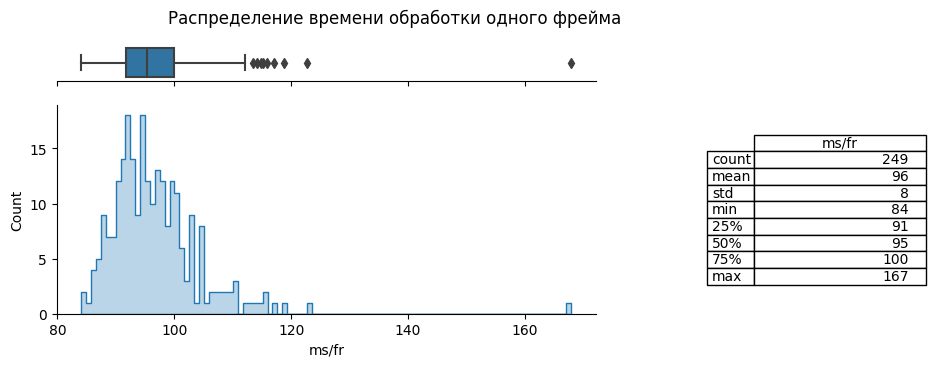

In [22]:
# для просмотра распределения времени здесь и во всех последующих трекерах убираем замер на первом фрейме;
# это время кратно выше остальных (выброс); возможно, связано с 1-ым использованием ф-ии model.track
description(track_data[1][1:])

In [23]:
# все видео в тетради
# реальная продолжительность 20 с; с учётом показанного замедления 41 с

# для GitHub c отдельно приложенной папкой с видео; в тетраде ссылки
# gif; 640х464
# fps=3; записывались нечётные фреймы, каждый 2-ой
# из mp4 в gif с помощью https://cloudconvert.com/mp4-to-gif

# если видео встроено в тетрадь
# gif; 600х436
# fps=2; записывались фреймы через 2, каждый 3-ий
# из mp4 в gif с помощью моб.прил. GIF MAKER-EDITOR; кач-во оптимизировано и ухудшено до 30

Трекинг фреймов с 1 до 250

![botsort_1-250.gif](pics/botsort_1-250.gif)

## ByteTrack (Ultralytics)

In [24]:
model = YOLO(yolo_weights)

In [25]:
track_data = ultralytics_tracking(tracker='bytetrack.yaml', fr_min=251, fr_max=501)

  0%|          | 0/250 [00:00<?, ?it/s]

In [26]:
motMetricsEnhancedCalculator(gt_path, track_data[0], fr_min=251, fr_max=501)

,num_frames,recall,precision,num_objects,num_switches,mota,motp
acc,250,0.742038,0.805532,1256,15,0.550955,0.243669


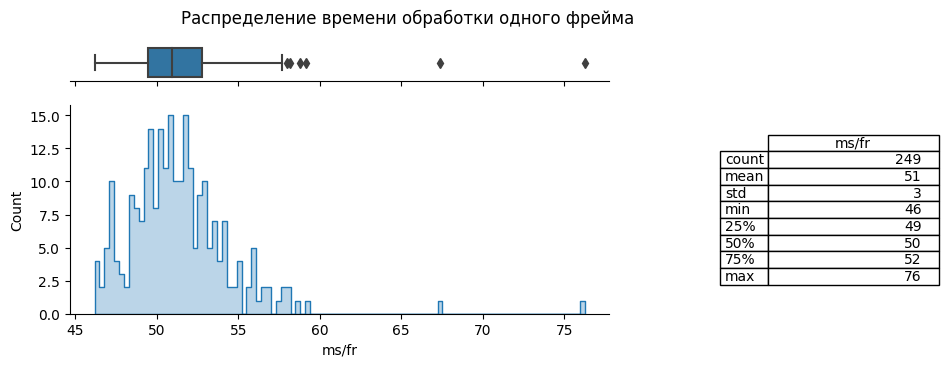

In [27]:
description(track_data[1][1:])

Трекинг фреймов с 251 до 500

![bytetrack_251-500.gif](pics/bytetrack_251-500.gif)

## SORT

In [28]:
class ObjectDetection:
    
    def __init__(self, capture_index):
        self.capture_index = capture_index
        self.model = self.load_model()
        self.track_history = defaultdict(lambda: [])
        self.CLASS_NAMES_DICT = self.model.model.names    # ?
        
    def load_model(self):
        model = YOLO(yolo_weights)
        model.fuse()  # https://docs.ultralytics.com/reference/engine/model/#ultralytics.engine.model.Model.fuse
        return model
    
    def predict(self, frame):
        results = self.model(frame, verbose=False)
        return results
    
    def get_results(self, results, fr):
        detections = []
        for result in results[0]:           # extract detections / берутся поочереди bbox'ы
            xyxy = result.boxes.xyxy.cpu().numpy()
            xywh = result.boxes.xywh.cpu().numpy()
            conf = result.boxes.conf.cpu().numpy()
            cls  = result.boxes.cls.cpu().numpy()
            
            merged_detection = [fr, xywh[0][0], xywh[0][1], xywh[0][2], xywh[0][3],
                                    xyxy[0][0], xyxy[0][1], xyxy[0][2], xyxy[0][3], conf[0], cls[0]]
            
            detections.append(merged_detection)
        return np.array(detections)
    
    def draw_bounding_boxes_with_id(self, img, bboxes, ids):
        for bbox, id_ in zip(bboxes, ids):
            cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0,0,255), 2)
            cv2.putText(img, "ID: "+str(id_), (int(bbox[0]), int(bbox[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
            
            # Plot the tracks
            x_center = int(bbox[0]+(bbox[2]-bbox[0])/2)
            y_center = int(bbox[1]+(bbox[3]-bbox[1])/2)
            track = self.track_history[id_]
            track.append((x_center, y_center))
            
            if len(track) > 30:                 # ограничение длины хвоста
                track.pop(0)
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(img, [points], isClosed=False, color=(0, 255, 255), thickness=10)
        return img
    
    def scale_image(self, cap, img, new_width):
        actual_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        actual_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        aspect_ratio = actual_width / actual_height
        img = cv2.resize(img, (new_width, int(new_width/aspect_ratio)))
        return img
        
    def __call__(self, max_age=100, min_hits=8, iou_threshold=0.5, fr_min=1, fr_max=11):
        cap = cv2.VideoCapture(self.capture_index)
        cap.set(cv2.CAP_PROP_POS_FRAMES,fr_min-1)
        assert cap.isOpened()
        
        # инициализация объекта для записи видео; активны эта строка и ещё две нижи (writer, realise)
        #out_video = create_video_writer(cap, "sort_tracking.mp4", 640, 464) # 1280x928,640x464,400х290
        
        # SORT
        sort = Sort(max_age=max_age, min_hits=min_hits, iou_threshold=iou_threshold)
        
        self.detections_for_mota = []
        self.frame_time = []

        for i in tqdm(range(fr_min,fr_max)):          # задаём номера фреймов для обработки из видео
            start = datetime.datetime.now()
            ret, frame = cap.read()                   # только array (картинка)
            assert ret                                # необходимо скорее для цикла while
            
            results = self.predict(frame)  # передаём array, получаем общую инфу о bbox'ах, классах и др. (без id трека)
            
            # array; в строке по каждому bbox: фрейм/x_центр/y_центр/ширина/высота/лево/верх/право/низ/вероятность/класс
            detections = self.get_results(results, i)
            
            # SORT Tracking
            if len(detections) == 0:           # если на кадре нет bbox'ов - пустой array
                detections = np.empty((0,11))
                
            # обновляются координаты bbox (уточнение от ф.Калмана и Венгерского алг.), 5-ое значение - присвоенный трек-id
            res = sort.update(detections[:,5:10]) # подаём x_left, y_top, x_right, y_bottom, conf
                        
            boxes_track = res[:,:-1]            # обрезается правый столбец с треком, остаются только координаты bbox
            boxes_ids = res[:,-1].astype(int)   # номера треков
            
            frame = self.draw_bounding_boxes_with_id(frame, boxes_track, boxes_ids)
            frame = self.scale_image(cap, frame, new_width = 640)
            
            #cv2.imshow('tracking of plastic bottles', frame)
            
                        
            detections_for_mota_fr = np.hstack([np.array([i]*len(res)).reshape(-1,1),        # frame
                                                res[:,[4,0,1]],                              # трек id, лево, верх
                                                (res[:,2]-res[:,0]).reshape(-1,1),           # ширина
                                                (res[:,3]-res[:,1]).reshape(-1,1)])          # высота
            
            self.detections_for_mota.append(detections_for_mota_fr)
            
            end = datetime.datetime.now()
            self.frame_time.append((end - start).total_seconds() * 1000)
           
            #if cv2.waitKey(1) & 0xFF == ord('q'):
            #    break
            
            #if i%3==0:                           # записываем каждый третий фрейм
            #    out_video.write(frame)
        
        self.detections_for_mota = np.vstack(self.detections_for_mota)
        
        cap.release()
        #cv2.destroyAllWindows()
        #out_video.release()

In [29]:
detector = ObjectDetection(capture_index=video_А24)

YOLOv10x summary (fused): 503 layers, 31,612,970 parameters, 0 gradients, 169.9 GFLOPs


In [30]:
# оптимальные гиперпараметры подобраны перебором
detector(max_age=40, min_hits=1, iou_threshold=0.3, fr_min=501, fr_max=751)

  0%|          | 0/250 [00:00<?, ?it/s]

In [31]:
motMetricsEnhancedCalculator(gt_path, detector.detections_for_mota, fr_min=501, fr_max=751)

,num_frames,recall,precision,num_objects,num_switches,mota,motp
acc,250,0.914043,0.977252,1175,18,0.877447,0.147942


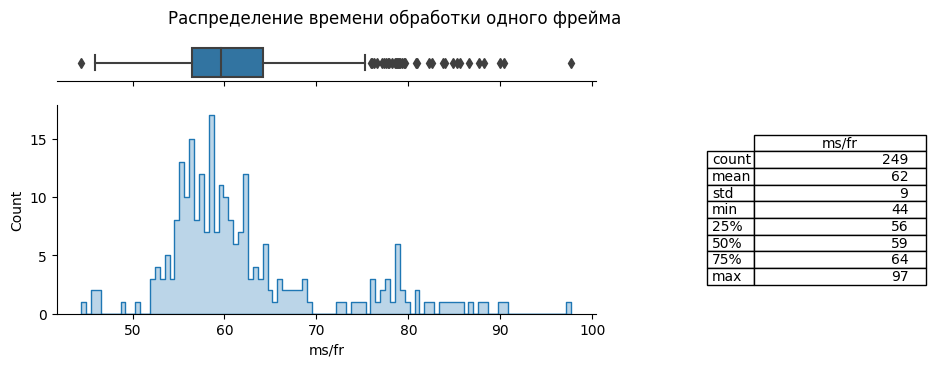

In [32]:
description(detector.frame_time[1:])

Трекинг фреймов с 501 до 750

![sort_501-750.gif](pics/sort_501-750.gif)

## DeepSORT

In [33]:
def deepsort(video=video_А24, fr_min=1, fr_max=11, CONFIDENCE_THRESHOLD = 0.7):
    '''детектирует объекты с помощью YOLO и отслеживает их с трекером DeepSORT;
       на выходе разметка (fr, id-track, x_left, y_top, w, h) и длительность обработки фрема (мс)'''
    # инициализируем цветовую карту (у каждого bbox'а с определённым треком будет свой цвет)
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

    # load the pre-trained YOLO model
    model = YOLO(yolo_weights)

    # инициализируем трекер с оптимальными гиперпараметрами (подобраны перебором)
    tracker = DeepSort(max_age=3, max_iou_distance=0.8)

    # initialize the video capture object
    cap = cv2.VideoCapture(video)
    cap.set(cv2.CAP_PROP_POS_FRAMES,fr_min-1)

    detections_for_mota = []
    track_history = defaultdict(lambda: [])
    frame_time = []

    # инициализация объекта для записи видео; активны эта строка и ещё две нижи (writer, realise)
    #writer_deepsort = create_video_writer(cap, "output_deepsort.mp4", 640, 464) # 1280x928,640x464,400х290

    # запускаем цикл по нужному количеству кадров видео
    for i in tqdm(range(fr_min, fr_max)):
        start = datetime.datetime.now()
        ret,frame = cap.read()
        detections = model(frame, verbose=False)[0]   # запускаем модель YOLO на фрейме
    
        results = []                                  # список для записи результатов детекции
    
        # проходим в цикле по каждому результату детекции (bbox'у)
        for data in detections.boxes.data.tolist():
            confidence = data[4]                      # вероятность существования данного объекта
            if confidence < CONFIDENCE_THRESHOLD:
                continue
            xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
            class_id = int(data[5])
            results.append([[xmin, ymin, xmax-xmin, ymax-ymin], confidence, class_id])
        
        # TRACKING
        # update the tracker with the new detections
        tracks = tracker.update_tracks(results, frame=frame) # подаём ltwh, в отличии от SORT - ltrb
        
        # loop over the tracks
        for track in tracks:
            # get the track id and bounding box
            track_id = int(track.track_id)
            # оригинальные координаты из детектора; если YOLO производит достаточно точные и стабильные предсказания, 
            # то использование этих координат приводит к более высокому значению MOTA; если детектор не может улучшить 
            # эти предсказания из-за шумов или ошибок в трекинге, то результат будет хуже.
            ltrb = track.to_ltrb(orig=True)
            ltwh = track.to_ltwh(orig=True)
        
            score = track.det_conf
            class_id = track.det_class
        
            #исключаем фантомные bbox'ы, которые создал трекер; координаты есть, а score = None; 
            #т.к. score подтягивается из детектора, а там этого bbox'а нет
            if score is None:
                continue
        
            xmin, ymin, xmax, ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])
        
            detections_for_mota_bbox = np.hstack([i, track_id, ltwh])
            detections_for_mota.append(detections_for_mota_bbox)
        
            # рисуем bbox и добавляем подписи
            color = colors[int(track_id) % len(colors)]
            color = [i * 255 for i in color]
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 3)
            cv2.rectangle(frame, (xmin, ymin-30), (xmax, ymin), color, -1)
            cv2.putText(frame,
                        "track_id: " + str(track_id) + "-" + "class " + str(class_id),
                         (xmin, ymin-10), 0, 0.75, (255,255,255), 2)

            # находим координаты центра bbox
            cx, cy = int((xmin+xmax)/2), int((ymin+ymax)/2)

            track_info = track_history[track]
            track_info.append((cx, cy))
            if len(track_info) > 30:
                track_info.pop(0)

            # получаем линию трека
            points = np.hstack(track_info).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(frame, [points], isClosed=False, color=(0, 255, 255), thickness=10)
        
        end = datetime.datetime.now()
        frame_time.append((end - start).total_seconds() * 1000)
    
        fps = f"FPS: {1 / (end - start).total_seconds():.2f}"       # расчет количества фреймов в секунду
        cv2.putText(frame, fps, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 8)
        
        actual_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))       # масштабируем окно вывода
        actual_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        aspect_ratio = actual_width / actual_height
        frame = cv2.resize(frame, (640, int(640/aspect_ratio)))     # 1280x928,640x464,400х290
     
        #cv2.imshow('tracking',frame)                                 # вывод результата
        
        #if i%3==0:                                                   # запись каждого третьего фрейма
        #    writer_deepsort.write(frame)                             # запись видео
        
        #if cv2.waitKey(1) == ord('q'):
        #    break
        
    cap.release()
    #cv2.destroyAllWindows()
    #writer_deepsort.release()
    
    return np.vstack(detections_for_mota), frame_time

In [34]:
track_data = deepsort(fr_min=751, fr_max=1001)

  0%|          | 0/250 [00:00<?, ?it/s]

In [35]:
motMetricsEnhancedCalculator(gt_path, track_data[0], fr_min=751, fr_max=1001)

,num_frames,recall,precision,num_objects,num_switches,mota,motp
acc,250,0.981629,0.998375,1252,19,0.964856,0.069013


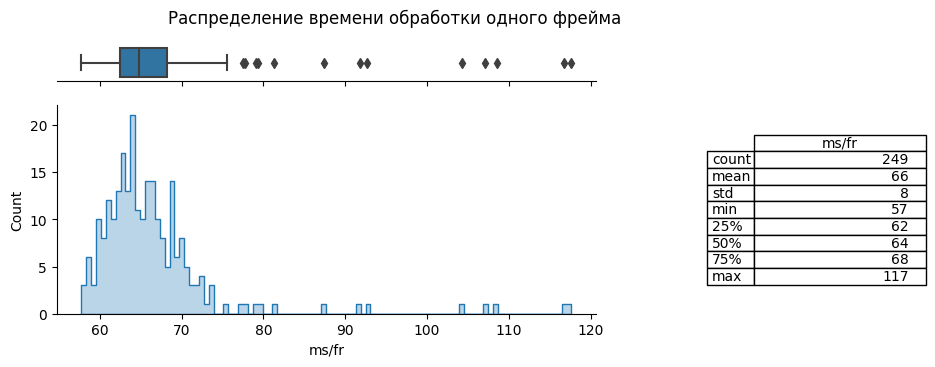

In [36]:
description(track_data[1][1:])

Трекинг фреймов с 751 до 1000:

![deepsort_751_1000.gif](pics/deepsort_751_1000.gif)

## Checking the best tracker

Наилучший результат MOTA показал DeepSORT.\
Проверим его визуально на нечётких смазанных видео.

Видео А58.\
Трекинг фреймов с 1 до 250

![a58_deepsort_1-250.gif](pics/a58_deepsort_1-250.gif)

Видео А32.\
Трекинг фреймов с 1 до 250

![a32_deepsort_1-250.gif](pics/a32_deepsort_1-250.gif)

Проверка DeepSORT на всём размеченном датасете 9000 фреймов

In [37]:
track_data = deepsort(fr_min=1, fr_max=9001)

  0%|          | 0/9000 [00:00<?, ?it/s]

In [38]:
motMetricsEnhancedCalculator(gt_path, track_data[0], fr_min=1, fr_max=9001)

,num_frames,recall,precision,num_objects,num_switches,mota,motp
acc,9000,0.979046,0.998575,46531,1038,0.955342,0.045139


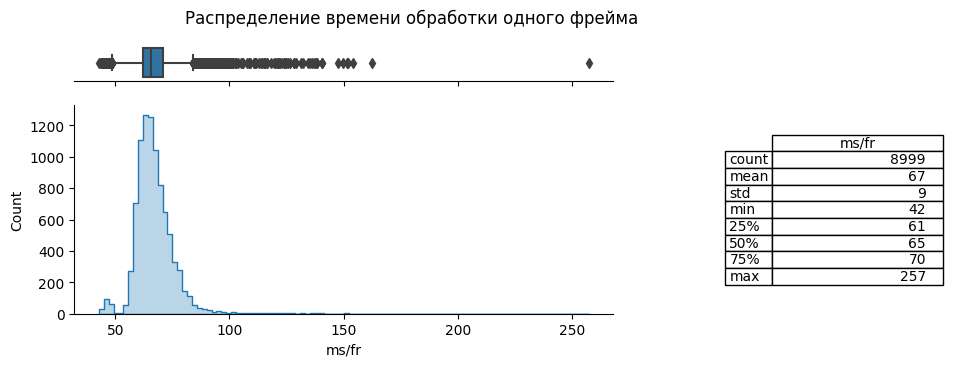

In [39]:
description(track_data[1][1:])

Причины, которые вероятно появлияли на хороший результат трекера DeepSORT:
1) взяты координаты bbox'ов из детектора; оказалось они более точные чем отредактированные трекером.\
Комментарий GPT:
Если YOLO производит достаточно точные и стабильные предсказания, то использование этих координат может привести к более высокому значению MOTA. Если DeepSORT не может улучшить эти предсказания из-за шумов или ошибок в трекинге, то результат будет хуже.

2) исключены фантомные bbox'ы, которые создал трекер; координаты bbox'ов есть, а score = None; т.к. score подтягивается из детектора, а там этого bbox'а нет.

## Сonclusion

Для улучшения работы отслеживания объектов на ленте было протестировано 4 трекера: 

| Трекер | MOTA | Время обработки фрейма (мс) <br> среднее/медиана на 250 фр |
| --- | --- | :-: |
| BotSORT | 0.9181 | 96 / 95 |
| ByteTrack | 0.5510 | 51 / 50 |
| SORT | 0.8774 | 62 / 59 |
| DeepSORT | 0.9649 | 66 / 64 |

Наилучшие показатели ключевой метрики были получены трекером DeepSORT.\
Результат MOTA на всём размеченном участке (9000 фреймов) = 0.9553.

MOTA измерена с помощью motmetrics при гиперпараметре max_iou=0.5.

Опираясь на визуальный контроль, можно сказать что все испытанные трекеры хорошо справляются с задачей.\
Однако, при смазанных видео трекинг значительно ухудшается: не идентифицируются многие объекты, теряются треки.

Специфика работы детектора приводит к тому, что в начале и в конце движения объекта треки меняют направление.\
Трек находится в центре bbox'а. При появлении и исчезновении объекта габариты bbox'а меняются, и следовательно его центр.

Также одна из основных проблем процесса "отлова" объекта и перенос манипулятором в соответсвующую корзину - перекатывание круглых предметов.

Рекомендации:
- применять трекер DeepSORT совместно с детектором YOLO;
- использовать чёткое несмазанное изображение; хорошо подсветить место работы камеры и контролировать чтобы был нормальный фокус;
- для передачи в манипулятор брать координаты после остановки объекта (трек - прямая) и не доходя некоторое расстояние до исчезновения объекта из кадра, например 10% от высоты изображения;
- необходима достаточно длинная лента, чтобы круглые объекты успевали остановиться; также можно применить рельефную ленту.

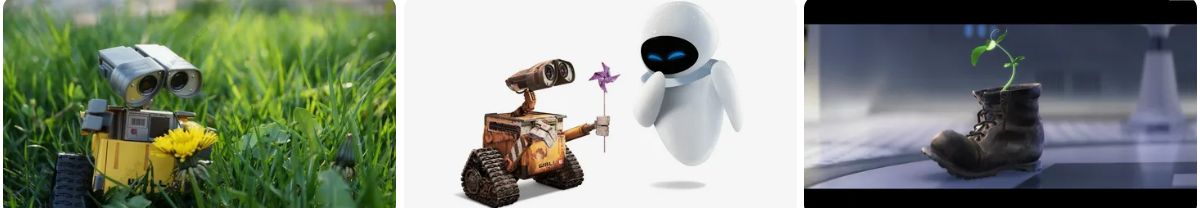